In [1]:
import argparse
import torch
import functools
import random
from collections import OrderedDict
import numpy as np
import os
import shutil
from torchvision.utils import save_image, make_grid
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import wandb
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from tqdm import tqdm
import gc

In [2]:
from typing import List, Optional, Tuple, Union
import math
import torch.nn as nn
from easydict import EasyDict
from PIL import Image

from diffusers.utils.torch_utils import randn_tensor
from utils import DDIMSolver, update_ema, guidance_scale_embedding, append_dims, extract, set_seed
from utils import scalings_for_boundary_conditions, get_predicted_original_sample, get_predicted_noise, get_ddim_timesteps
from diffusers.optimization import get_scheduler
from diffusers.schedulers import LCMScheduler

In [3]:
from dataset import CustomImageDataset
from models.sampler import ImbalancedDatasetSampler
from torch.utils.data import DataLoader

from models.engine import DDIMSampler, DDIMSamplerEncoder
from utils_ccdm import get_model
from models.embedding import TimeEmbedding, ConditionalEmbedding, LabelEmbedding
from models.ddpm_scheduler import NoiseScheduler
from models.attention import SpatialTransformer, AttentionBlock
from models.unet import Swish, UpSample, DownSample, AdaGroupNorm, TimestepEmbedSequential, ResBlock, ResBlockCond, ResBlockAdaGN, ResBlockImageClassConcat
from models.unet import UNet, UNetIC
from config import Zappo50K, toy_dataset, CelebA, Colored_MNIST

In [12]:
def denormalize(images: Union[np.ndarray, torch.Tensor]) -> Union[np.ndarray, torch.Tensor]:
    r"""
    Denormalize an image array to [0,1].

    Args:
        images (`np.ndarray` or `torch.Tensor`):
            The image array to denormalize.

    Returns:
        `np.ndarray` or `torch.Tensor`:
            The denormalized image array.
    """
    return (images / 2 + 0.5).clamp(0, 1)


In [ ]:
sampler_model = get_model()

In [6]:
def run_eval_and_log(model, noise_scheduler, args, accelerator, epoch, weight_dtype=torch.float32, name="target"):
        # need to import dataaset CFG
        num_atr, num_obj = args.num_condition[0], args.num_condition[1]
        n_samples =  num_atr * num_obj

        sampler = ConsisctencySampler(model.eval(), noise_scheduler, n_samples = n_samples ,device=accelerator.device)
        
        if args.seed is None:
            generator = None
        else:
            generator = torch.Generator(device=device).manual_seed(args.seed)        
        
        # create conditions of each class
        # create conditions like [0,0,0,1,1,1, ...] [0,1,2,3,0,1,2,3, ...]
        c1 = torch.arange(0, num_atr)
        c2 = torch.arange(0, num_obj)
        c1 = c1.repeat(n_samples // num_atr, 1).permute(1, 0).reshape(-1)
        c2 = c2.repeat(n_samples // num_obj)
        c1, c2 = c1.to(device), c2.to(device)
    
        # create noise
        x_t = torch.randn(n_samples, 3, args.img_size, args.img_size).to(device=device, dtype=torch.float32)
        
        images = sampler(
                    c1, 
                    c2,
                    x_t = x_t, 
                    num_inference_steps = 4,
                    guidance_scale = 3.5,
                    generator=generator,
                 )

        # save image
        os.makedirs(os.path.join('result', args.exp, args.save_path), exist_ok=True)
        save_image(images, os.path.join('result', args.exp, args.save_path, f'epoch_{epoch}.png'))

        # log image
        images = images.permute(0, 2, 3, 1)
        images = images.cpu().detach().numpy()
        c1, c2 = c1.cpu().detach().numpy(), c2.cpu().detach().numpy()
        images = [(f"{CFG.IDX2ATR[c1[i]]} {CFG.IDX2OBJ[c2[i]]}", images[i, :, :, :]) for i in range(n_samples)]
        accelerator.log({f"evalution epoch {epoch+1}": [wandb.Image(img, caption=label) for label, img in images]})
        
        del sampler
        gc.collect()
        torch.cuda.empty_cache()
        
        return images

In [6]:
class ConsisctencySampler(nn.Module):
    def __init__(self, unet, noise_scheduler, n_samples, device):
        super().__init__()
        self.unet = unet,
        self.scheduler = LCMScheduler(
                            beta_schedule = noise_scheduler.config.beta_schedule, 
                            beta_start = noise_scheduler.beta_start, 
                            beta_end = noise_scheduler.beta_end, 
                            clip_sample = True
                        )
        self.x_shape = (n_samples, 3, args.img_size, args.img_size)
        # self.guidance_scale = 
        self.device = device
    
    # Copied from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.retrieve_timesteps
    def retrieve_timesteps(
        self,
        num_inference_steps: Optional[int] = None,
        timesteps: Optional[List[int]] = None,
        sigmas: Optional[List[float]] = None,
        **kwargs,
    ):
        """
        Calls the scheduler's `set_timesteps` method and retrieves timesteps from the scheduler after the call. Handles
        custom timesteps. Any kwargs will be supplied to `scheduler.set_timesteps`.

        Args:
            scheduler (`SchedulerMixin`):
                The scheduler to get timesteps from.
            num_inference_steps (`int`):
                The number of diffusion steps used when generating samples with a pre-trained model. If used, `timesteps`
                must be `None`.
            device (`str` or `torch.device`, *optional*):
                The device to which the timesteps should be moved to. If `None`, the timesteps are not moved.
            timesteps (`List[int]`, *optional*):
                Custom timesteps used to override the timestep spacing strategy of the scheduler. If `timesteps` is passed,
                `num_inference_steps` and `sigmas` must be `None`.
            sigmas (`List[float]`, *optional*):
                Custom sigmas used to override the timestep spacing strategy of the scheduler. If `sigmas` is passed,
                `num_inference_steps` and `timesteps` must be `None`.

        Returns:
            `Tuple[torch.Tensor, int]`: A tuple where the first element is the timestep schedule from the scheduler and the
            second element is the number of inference steps.
        """
        if timesteps is not None and sigmas is not None:
            raise ValueError("Only one of `timesteps` or `sigmas` can be passed. Please choose one to set custom values")
        if timesteps is not None:
            accepts_timesteps = "timesteps" in set(inspect.signature(self.scheduler.set_timesteps).parameters.keys())
            if not accepts_timesteps:
                raise ValueError(
                    f"The current scheduler class {self.scheduler.__class__}'s `set_timesteps` does not support custom"
                    f" timestep schedules. Please check whether you are using the correct scheduler."
                )
            self.scheduler.set_timesteps(timesteps=timesteps, device=self.device, **kwargs)
            timesteps = self.scheduler.timesteps
            num_inference_steps = len(timesteps)
        elif sigmas is not None:
            accept_sigmas = "sigmas" in set(inspect.signature(self.scheduler.set_timesteps).parameters.keys())
            if not accept_sigmas:
                raise ValueError(
                    f"The current scheduler class {self.scheduler.__class__}'s `set_timesteps` does not support custom"
                    f" sigmas schedules. Please check whether you are using the correct scheduler."
                )
            self.scheduler.set_timesteps(sigmas=sigmas, device=self.device, **kwargs)
            timesteps = self.scheduler.timesteps
            num_inference_steps = len(timesteps)
        else:
            self.scheduler.set_timesteps(num_inference_steps, device=self.device, **kwargs)
            timesteps = self.scheduler.timesteps
        return timesteps, num_inference_steps
    
    def get_guidance_scale_embedding(
        self, w: torch.Tensor, embedding_dim: int = 256, dtype: torch.dtype = torch.float32
    ) -> torch.Tensor:
        """
        Args:
            w (`torch.Tensor`):
                Generate embedding vectors with a specified guidance scale to subsequently enrich timestep embeddings.
            embedding_dim (`int`, *optional*, defaults to 512):
                Dimension of the embeddings to generate.
            dtype (`torch.dtype`, *optional*, defaults to `torch.float32`):
                Data type of the generated embeddings.

        Returns:
            `torch.Tensor`: Embedding vectors with shape `(len(w), embedding_dim)`.
        """
        assert len(w.shape) == 1
        w = w * 1000.0

        half_dim = embedding_dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=dtype) * -emb)
        emb = w.to(dtype)[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        if embedding_dim % 2 == 1:  # zero pad
            emb = torch.nn.functional.pad(emb, (0, 1))
        assert emb.shape == (w.shape[0], embedding_dim)
        return emb
    
    @torch.no_grad()
    def forward(self,
                c1: torch.LongTensor, 
                c2: torch.LongTensor,
                x_t: Optional[torch.Tensor] = None,
                num_inference_steps: int = 4,
                timesteps: List[int] = None,
                height:Optional[int] = None,
                width: Optional[int] = None,
                guidance_scale: float = 3.5,
                num_images_per_cond: Optional[int] = 1,
                generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
                return_dict: bool = False,
                ):
        """
        Args:
            c1 (`torch.LongTensor`): 
                attribute condition.
            c2 (`torch.LongTensor`): 
                object condition.
            x_t (`torch.Tensor`): 
                Noisy images at timestep t with shape (batch_size, channels, height, width).
            num_inference_steps (`int`, *optional*, defaults to 4):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            height (`int`, *optional*, defaults to 64):
                The height in pixels of the generated image.
            width (`int`, *optional*, defaults to 64):
                The width in pixels of the generated image.
            original_inference_steps (`int`, *optional*):
                The original number of inference steps use to generate a linearly-spaced timestep schedule, from which
                we will draw `num_inference_steps` evenly spaced timesteps from as our final timestep schedule,
                following the Skipping-Step method in the paper (see Section 4.3). If not set this will default to the
                scheduler's `original_inference_steps` attribute.
            timesteps (`List[int]`, *optional*):
                Custom timesteps to use for the denoising process. If not defined, equal spaced `num_inference_steps`
                timesteps on the original LCM training/distillation timestep schedule are used. Must be in descending
                order.
            guidance_scale (`float`, *optional*, defaults to 3.5):
                A higher guidance scale value encourages the model to generate images closely linked to the text
                `prompt` at the expense of lower image quality. Guidance scale is enabled when `guidance_scale > 1`.
                Note that the original latent consistency models paper uses a different CFG formulation where the
                guidance scales are decreased by 1 (so in the paper formulation CFG is enabled when `guidance_scale >
                0`).
            num_images_per_cond (`int`, *optional*, defaults to 1):
                The number of images to generate per condition.
            generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
                A [`torch.Generator`] to make generation deterministic.

        Returns:
            will return a tensor with shape (batch_size, channels, height, width),
            otherwise, return a tensor with shape (batch_size, sample, channels, height, width),
            include intermediate pictures.
            
        """
        # 0. Default height and width to unet
        height = height or args.img_size
        width = width or args.img_size
        
        # 4. Prepare timesteps
        timesteps, num_inference_steps = self.retrieve_timesteps(num_inference_steps, timesteps)
        # 5. Prepare noise
        if x_t is None:
            if generator is None:
                print("No noise or seed provided for sampler, going to sample random noises.")
            x_t = randn_tensor(x_shape, generator=generator, device=self.device, dtype=torch.float32)
            x_t = x_t * self.scheduler.init_noise_sigma
        
        else:
            x_t = randn_tensor(x_shape, generator=generator, device=self.device, dtype=torch.float32) if generator else x_t
            
        
        bs = self.x_shape[0] * num_images_per_cond
        
        # 6. Get Guidance Scale Embedding
        # NOTE: We use the Imagen CFG formulation that StableDiffusionPipeline uses rather than the original LCM paper
        # CFG formulation, so we need to subtract 1 from the input guidance_scale.
        # LCM CFG formulation:  cfg_noise = noise_cond + cfg_scale * (noise_cond - noise_uncond), (cfg_scale > 0.0 using CFG)
        w = torch.tensor(guidance_scale - 1).repeat(bs)
        w_embedding = self.get_guidance_scale_embedding(w, embedding_dim=args.time_cond_proj_dim).to(
            device=device, dtype=x_t.dtype
        )
        
        # 8. LCM MultiStep Sampling Loop: implements Algorithm 1 in the paper
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        # self._num_timesteps = len(timesteps)
        
        with tqdm(reversed(range(num_inference_steps)), colour="#6565b5", total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                x_t = x_t.to(dtype=torch.float32)

                # model prediction (eps)
                noise_pred = unet(
                    x_t,
                    t,
                    c1,
                    c2,
                    timestep_cond=w_embedding,
                )

                # compute the previous noisy sample x_t -> x_t-1
                x_t, denoised = self.scheduler.step(noise_pred, t, x_t, return_dict=False)
                
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
        
        # denormalize
        image = denormalize(denoised)
        
        # Offload all models
        # self.maybe_free_model_hooks()        
        
        return image
        
  

### update: cond_proj_dim

### UNet with timestep_condition ( for guidance scale )

In [4]:
class Args(argparse.Namespace):
    def __init__(self,
                 arch = "unetic",
                 data = r"data/mnist_5x10_64",
                 exp = "colored_mnist",
                 savepath = "cd_5x10_IC",
                 pretrained_weight_nums_cond = [5,10],
                 num_condition = [5,10],
                 img_size = 64,
                 train_batch_size = 64,
                 learning_rate = 1e-5,
                 epochs = 30,
                 num_timestep = 1000,
                 emb_size = 128,
                 time_cond_proj_dim = 128,  
                 num_res_blocks = 2,
                 channel_mult = [1, 2, 2, 2],
                 adam_beta1=0.9,
                 adam_beta2=0.999,
                 adam_weight_decay=1e-2,
                 adam_epsilon=1e-08,     
                 lr_warmup_steps=500,
                 #projection_dim = 512,
                 #num_heads = 4,
                 #num_head_channels = -1,
                 #use_spatial_transformer = True,
                 timestep_scaling_factor = 10,
                 w_interval = [2.8, 2.8],
                 num_ddim_timesteps = 50,
                 only_table = False,
                 concat = False,
                 only_encoder = False,
                 encoder_path = None,
                 compose=False,
                 loss_type = "huber",
                 huber_c = 0.001,
                 ema_decay = 0.95,
                 checkpointing_steps = 100,
                 eval_interval = 100,
                 checkpoints_total_limit=6,
                 max_grad_norm=1.0,
                 seed=None,
                 **kwargs
                ):
        
        super().__init__()
        # Assign the provided arguments as attributes of the class
        self.arch = arch
        self.data = data
        self.exp = exp
        self.save_path = savepath
        self.num_condition = num_condition
        self.pretrained_weight_nums_cond = pretrained_weight_nums_cond
        self.img_size = img_size
        self.train_bs = train_batch_size
        self.lr = learning_rate
        self.epochs = epochs
        self.num_timestep = num_timestep
        self.emb_size = emb_size
        self.time_cond_proj_dim = time_cond_proj_dim   
        self.num_res_blocks = num_res_blocks
        self.channel_mult = channel_mult
        self.adam_beta1 = adam_beta1
        self.adam_beta2 = adam_beta2
        self.adam_weight_decay = adam_weight_decay
        self.adam_epsilon = adam_epsilon
        self.lr_warmup_steps=lr_warmup_steps
        self.lr_scheduler="constant"
        #    'The scheduler type to use. Choose between ["linear", "cosine", "cosine_with_restarts", "polynomial",'
        #   ' "constant", "constant_with_warmup"]'
        
        #self.projection_dim = projection_dim
        #self.num_heads = num_heads
        #self.num_head_channels = num_head_channels
        #self.use_spatial_transformer = use_spatial_transformer
        self.timestep_scaling_factor = timestep_scaling_factor
        self.w_interval = w_interval
        self.num_ddim_timesteps = num_ddim_timesteps
        #self.mixed_precision = mixed_precision
        self.only_table = only_table
        self.concat = concat
        self.only_encoder = only_encoder
        self.encoder_path = encoder_path
        self.compose=compose
        self.seed=seed
        self.loss_type = loss_type
        self.huber_c = huber_c
        self.ema_decay = ema_decay
        self.checkpointing_steps = checkpointing_steps
        self.checkpoints_total_limit = checkpoints_total_limit
        self.eval_interval = eval_interval
        self.max_grad_norm = max_grad_norm
        
        for key, value in kwargs.items():
            setattr(self, key, value)
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = Args()



In [69]:
#wandb.login(key="9ec9f428aa2ba6c0a93c8f4358d92ba00a94b2b7") 
# run = wandb.init(
#     project=args.exp,
#     config={
#         "dataset": args.data.split('/')[-1],
#         "img_size": args.img_size,
#         "epochs": args.epochs,
#         "learning_rate": args.lr,
#         "num_ddim_timesteps": args.num_ddim_timesteps,
#         "guidance scale interval": args.w_interval,
#     },
#     job_type="training"
# )
run.finish()

In [8]:
accelerator = Accelerator(log_with="wandb", gradient_accumulation_steps=1)

if args.seed is not None:
    set_seed(args.seed)

In [70]:
if accelerator.is_main_process:
    tracker_config = {
        "architecture": args.arch,
        "dataset": args.data.split('/')[-1],
        "experiment": args.exp,
        "dataset_nums_condition": args.num_condition,
        "pretrained_weight_nums_cond": args.pretrained_weight_nums_cond,
        "img_size": args.img_size,
        "train_batch_size": args.train_bs,
        "learning_rate": args.lr,
        "epochs": args.epochs,
        "guidance_scale_interval": args.w_interval,
        "num_ddim_timesteps": args.num_ddim_timesteps
    }
    
    accelerator.init_trackers(args.exp, config=tracker_config)

In [6]:
vars(args)

{'arch': 'unetic',
 'data': 'data/mnist_5x10_64',
 'exp': 'colored_mnist',
 'save_path': 'cd_5x10_IC',
 'num_condition': [5, 10],
 'pretrained_weight_nums_cond': [5, 10],
 'img_size': 64,
 'train_bs': 64,
 'lr': 1e-05,
 'epochs': 30,
 'num_timestep': 1000,
 'emb_size': 128,
 'time_cond_proj_dim': 128,
 'num_res_blocks': 2,
 'channel_mult': [1, 2, 2, 2],
 'adam_beta1': 0.9,
 'adam_beta2': 0.999,
 'adam_weight_decay': 0.01,
 'adam_epsilon': 1e-08,
 'lr_warmup_steps': 500,
 'lr_scheduler': 'constant',
 'timestep_scaling_factor': 10,
 'w_interval': [2.8, 2.8],
 'num_ddim_timesteps': 50,
 'only_table': False,
 'concat': False,
 'only_encoder': False,
 'encoder_path': None,
 'compose': False,
 'seed': None,
 'loss_type': 'huber',
 'huber_c': 0.001,
 'ema_decay': 0.95,
 'checkpointing_steps': 100,
 'checkpoints_total_limit': 6,
 'eval_interval': 100,
 'max_grad_norm': 1.0}

### 1. Create the noise scheduler and the desired noise schedule.

In [5]:
# ddpm NoiseScheduler calculates the alpha and sigma noise schedules (based on the alpha bars) for us
noise_scheduler = NoiseScheduler()

# Initialize the DDIM ODE solver for distillation.
solver = DDIMSolver(
    noise_scheduler.alphas_cumprod.numpy(),
    timesteps=noise_scheduler.config.num_train_timesteps,
    ddim_timesteps=args.num_ddim_timesteps,
    )

In [8]:
#del teacher_unet
teacher_unet = get_model(args, time_cond_proj_dim=128)
print(teacher_unet)

UNetIC(
  (time_embedding): TimeEmbedding(
    (cond_proj): Linear(in_features=128, out_features=128, bias=False)
    (emb_layer): Embedding(1000, 128)
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
    (act): Swish()
  )
  (atr_embedding): ConditionalEmbedding(
    (embedding_table): Embedding(6, 128)
    (emb): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Swish()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (obj_embedding): ConditionalEmbedding(
    (embedding_table): Embedding(11, 128)
    (emb): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Swish()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (head): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downblocks): ModuleList(
    (0): ResBlockImageClassConcat(
      (block1): Sequent

In [7]:
teacher_unet = UNetIC(
                   T=args.num_timestep,
                   num_atr=args.num_condition[0],
                   num_obj=args.num_condition[1],
                   model_channels=args.emb_size,
                   ch_mult=args.channel_mult,
                   num_res_blocks=args.num_res_blocks,
                   dropout=False,
               )

print(teacher_unet)

UNetIC(
  (time_embedding): TimeEmbedding(
    (emb_layer): Embedding(1000, 128)
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
    (act): Swish()
  )
  (atr_embedding): ConditionalEmbedding(
    (embedding_table): Embedding(6, 128)
    (emb): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Swish()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (obj_embedding): ConditionalEmbedding(
    (embedding_table): Embedding(11, 128)
    (emb): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Swish()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (head): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downblocks): ModuleList(
    (0): ResBlockImageClassConcat(
      (block1): Sequential(
        (0): GroupNorm(32, 128, eps=1e-05, affine=True)
        (1

### Load compositional conditional teacher U-Net 

In [21]:
#teacher_unet = get_model(args)
checkpoint = torch.load(r"checkpoints/colored_mnist/mnist5x10x64_ic.pth",map_location='cpu')["model"]

new_ckpt = OrderedDict()
for k, v in checkpoint.items():
    if k.startswith("module"):
        new_ckpt[k[7:]] = v
    else:
        new_ckpt[k] = v

# Load model parameters (with strict=False to allow some missing or extra keys)
missing_keys, unexpected_keys = teacher_unet.load_state_dict(new_ckpt, strict=False)
print("Missing keys:", missing_keys)
print("Unexpected keys:", unexpected_keys)

# Manually assign weights for special cases
for i in range(len(missing_keys)):
    assert missing_keys[i].split(".")[-1] == unexpected_keys[i].split(".")[-1]
    teacher_unet.state_dict()[missing_keys[i]].copy_(new_ckpt[unexpected_keys[i]])
    
# Freeze teacher_unet
teacher_unet.requires_grad_(False)

Missing keys: ['time_embedding.emb_layer.weight', 'time_embedding.linear_1.weight', 'time_embedding.linear_1.bias', 'time_embedding.linear_2.weight', 'time_embedding.linear_2.bias']
Unexpected keys: ['time_embedding.timembedding.0.weight', 'time_embedding.timembedding.1.weight', 'time_embedding.timembedding.1.bias', 'time_embedding.timembedding.3.weight', 'time_embedding.timembedding.3.bias']


UNetIC(
  (time_embedding): TimeEmbedding(
    (emb_layer): Embedding(1000, 128)
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
    (act): Swish()
  )
  (atr_embedding): ConditionalEmbedding(
    (embedding_table): Embedding(6, 128)
    (emb): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Swish()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (obj_embedding): ConditionalEmbedding(
    (embedding_table): Embedding(11, 128)
    (emb): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Swish()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (head): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downblocks): ModuleList(
    (0): ResBlockImageClassConcat(
      (block1): Sequential(
        (0): GroupNorm(32, 128, eps=1e-05, affine=True)
        (1

In [22]:
# checking
teacher_unet.state_dict()['time_embedding.linear_1.weight'] == new_ckpt['time_embedding.timembedding.1.weight']

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

### Create online student U-Net. Will be updated by the optimizer (e.g. backprop.)

In [17]:
# Add `time_cond_proj_dim` to the student U-Net
unet = get_model(args, args.time_cond_proj_dim)

# load teacher_unet weights into unet
unet.load_state_dict(teacher_unet.state_dict(), strict=False)

unet.train()

UNet(
  (time_embedding): TimeEmbedding(
    (cond_proj): Linear(in_features=128, out_features=128, bias=False)
    (emb_layer): Embedding(1000, 128)
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
    (act): Swish()
  )
  (atr_embedding): ConditionalEmbedding(
    (embedding_table): Embedding(7, 128)
    (emb): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Swish()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (obj_embedding): ConditionalEmbedding(
    (embedding_table): Embedding(7, 128)
    (emb): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Swish()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepE

In [18]:
#c checking cond_proj layer weight init
mk, uk = unet.load_state_dict(teacher_unet.state_dict(), strict=False)
nn.init.zeros_(unet.time_embedding.cond_proj.weight)

print(unet.time_embedding.cond_proj.weight)

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)


###  Create target student U-Net. This will be updated via EMA updates (polyak averaging).

In [19]:
# Initialize from (online) unet
target_unet = get_model(args, args.time_cond_proj_dim)
target_unet.load_state_dict(unet.state_dict(), strict=True)
target_unet.train()
target_unet.requires_grad_(False)

UNet(
  (time_embedding): TimeEmbedding(
    (cond_proj): Linear(in_features=128, out_features=128, bias=False)
    (emb_layer): Embedding(1000, 128)
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
    (act): Swish()
  )
  (atr_embedding): ConditionalEmbedding(
    (embedding_table): Embedding(7, 128)
    (emb): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Swish()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (obj_embedding): ConditionalEmbedding(
    (embedding_table): Embedding(7, 128)
    (emb): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Swish()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepE

### Move to device

In [20]:
unet.to(accelerator.device)
target_unet.to(accelerator.device)
teacher_unet.to(accelerator.device)
noise_scheduler.to(accelerator.device)
solver.to(accelerator.device)

### Optimizer creation

In [21]:
optimizer_class = torch.optim.AdamW

optimizer = optimizer_class(
    unet.parameters(),
    lr=args.lr,
    betas=(args.adam_beta1, args.adam_beta2),
    weight_decay=args.adam_weight_decay,
    eps=args.adam_epsilon,
)

### Dataset creation and data processing

In [87]:
transform  = transforms.Compose([
        transforms.Resize((args.img_size, args.img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_ds = CustomImageDataset(root=args.data, transform=transform)
balance_sampler = ImbalancedDatasetSampler(train_ds, labels=train_ds.labels)
dataloader = DataLoader(train_ds, batch_size=32, sampler=balance_sampler, num_workers=4)

CFG = toy_dataset()

In [23]:
print(len(dataloader))
print(CFG.ATR2IDX)
print(CFG.OBJ2IDX)

225
{'red': 0, 'green': 1, 'blue': 2, 'black': 3, 'yellow': 4, 'purple': 5}
{'Circle': 0, 'Rectangle': 1, 'Triangle': 2, 'Pentagon': 3, 'Oval': 4, 'Hexagon': 5}


### LR Scheduler creation

In [24]:
lr_scheduler = get_scheduler(
    args.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=args.lr_warmup_steps,
    num_training_steps=args.epochs*len(dataloader),
)

###  Prepare everything with our accelerator for training

In [25]:
unet, optimizer, lr_scheduler, dataloader = accelerator.prepare(unet, optimizer, lr_scheduler, dataloader)

In [26]:
global_step = 0
first_epoch = 0
initial_global_step = 0

In [27]:
#num_update_steps_per_epoch = math.ceil(len(dataloader) / args.gradient_accumulation_steps)
num_update_steps_per_epoch = len(dataloader)
max_train_steps = args.epochs * num_update_steps_per_epoch

progress_bar = tqdm(
    range(0, max_train_steps),
    initial=initial_global_step,
    desc="Steps",
    # Only show the progress bar once on each machine.
    disable=not accelerator.is_local_main_process,
)

# progress_bar = tqdm(dataloader, desc=f'Epoch {epoch}')

Steps:   0%|                                           | 0/6750 [00:00<?, ?it/s]

### Train Loop

In [35]:
# for epoch in range(first_epoch, args.epochs):
epoch = 1
#for step, batch in enumerate(dataloader):
step = 1
iter_data_loader = iter(dataloader) 

In [36]:
batch = next(iter_data_loader)
x = batch["image"].to(accelerator.device)
c1 = [CFG.ATR2IDX[a] for a in batch["atr"]]
c2 = [CFG.OBJ2IDX[o] for o in batch["obj"]]
c1 = torch.tensor(c1, dtype=torch.long, device=accelerator.device)
c2 = torch.tensor(c2, dtype=torch.long, device=accelerator.device)
bsz = x.shape[0]

print(batch)

{'image': tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.000

In [37]:
# 2. Sample a random timestep for each image t_n from the ODE solver timesteps without bias.
# For the DDIM solver, the timestep schedule is [T - 1, T - k - 1, T - 2 * k - 1, ...]
topk = noise_scheduler.config.num_train_timesteps // args.num_ddim_timesteps
index = torch.randint(0, args.num_ddim_timesteps, (bsz,), device=x.device).long()
start_timesteps = solver.ddim_timesteps[index]
timesteps = start_timesteps - topk
timesteps = torch.where(timesteps < 0, torch.zeros_like(timesteps), timesteps)

In [38]:
# 3. Get boundary scalings for start_timesteps and (end) timesteps.
c_skip_start, c_out_start = scalings_for_boundary_conditions(
    start_timesteps, timestep_scaling=args.timestep_scaling_factor
)
c_skip_start, c_out_start = [append_dims(c, x.ndim) for c in [c_skip_start, c_out_start]]
c_skip, c_out = scalings_for_boundary_conditions(
    timesteps, timestep_scaling=args.timestep_scaling_factor
)
c_skip, c_out = [append_dims(c, x.ndim) for c in [c_skip, c_out]]

In [39]:
# 4. Sample noise from the prior and add it to the latents according to the noise magnitude at each
# timestep (this is the forward diffusion process) [z_{t_{n + k}} in Algorithm 1]
noisy_model_input = noise_scheduler.add_noise(x, start_timesteps)

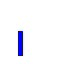

In [55]:
transforms.ToPILImage()(x[25])

tensor(79, device='cuda:0')


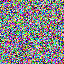

In [54]:
print(start_timesteps[25])
transforms.ToPILImage()(noisy_model_input[25])

In [56]:
# 5. Sample a random guidance scale w from U[w_min, w_max] and embed it
w = torch.empty(bsz).uniform_(args.w_interval[0], args.w_interval[1])
w_embedding = guidance_scale_embedding(w, embedding_dim=args.time_cond_proj_dim)
w = w.reshape(bsz, 1, 1, 1)
# Move to U-Net device and dtype
w = w.to(device=x.device, dtype=x.dtype)
w_embedding = w_embedding.to(device=x.device, dtype=x.dtype)

In [57]:
# 7. Get online LCM prediction on z_{t_{n + k}} (noisy_model_input), w, c, t_{n + k} (start_timesteps)
noise_pred = unet(
    noisy_model_input,
    start_timesteps,
    c1,
    c2,
    timestep_cond=w_embedding,
)

pred_x0 = get_predicted_original_sample(
    noise_pred,
    start_timesteps,
    noisy_model_input,
    noise_scheduler.config.prediction_type,
    noise_scheduler.alpha_schedule,
    noise_scheduler.sigma_schedule,
)

model_pred = c_skip_start * noisy_model_input + c_out_start * pred_x0

In [58]:
# 8. Compute the conditional and unconditional teacher model predictions to get CFG estimates of the
# predicted noise eps_0 and predicted original sample x_0, then run the ODE solver using these
# estimates to predict the data point in the augmented PF-ODE trajectory corresponding to the next ODE
# solver timestep.
with torch.no_grad():
    # 1. Get teacher model prediction on noisy_model_input z_{t_{n + k}} and conditional embedding c
    cond_teacher_output = teacher_unet(
        noisy_model_input,
        start_timesteps,
        c1,
        c2,
    )
    cond_pred_x0 = get_predicted_original_sample(
        cond_teacher_output,
        start_timesteps,
        noisy_model_input,
        noise_scheduler.config.prediction_type,
        noise_scheduler.alpha_schedule,
        noise_scheduler.sigma_schedule,
    )
    cond_pred_noise = get_predicted_noise(
        cond_teacher_output,
        start_timesteps,
        noisy_model_input,
        noise_scheduler.config.prediction_type,
        noise_scheduler.alpha_schedule,
        noise_scheduler.sigma_schedule,
    )

    
    # 2. Get teacher model prediction on noisy_model_input z_{t_{n + k}} and unconditional embedding 0
    uncond_teacher_output = teacher_unet(
        noisy_model_input,
        start_timesteps,
        c1,
        c2,
        force_drop_ids=True,
    )
    uncond_pred_x0 = get_predicted_original_sample(
        uncond_teacher_output,
        start_timesteps,
        noisy_model_input,
        noise_scheduler.config.prediction_type,
        noise_scheduler.alpha_schedule,
        noise_scheduler.sigma_schedule,
    )
    uncond_pred_noise = get_predicted_noise(
        uncond_teacher_output,
        start_timesteps,
        noisy_model_input,
        noise_scheduler.config.prediction_type,
        noise_scheduler.alpha_schedule,
        noise_scheduler.sigma_schedule,
    )
    
    # 3. Calculate the CFG estimate of x_0 (pred_x0) and eps_0 (pred_noise)
    # Note that this uses the LCM paper's CFG formulation rather than the Imagen CFG formulation
    pred_x0 = cond_pred_x0 + w * (cond_pred_x0 - uncond_pred_x0)
    pred_noise = cond_pred_noise + w * (cond_pred_noise - uncond_pred_noise)
    # 4. Run one step of the ODE solver to estimate the next point x_prev on the
    # augmented PF-ODE trajectory (solving backward in time)
    # Note that the DDIM step depends on both the predicted x_0 and source noise eps_0.
    x_prev = solver.ddim_step(pred_x0, pred_noise, index)    

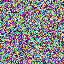

In [59]:
transforms.ToPILImage()(x_prev[25].squeeze())

In [60]:
with torch.no_grad():
    target_noise_pred = target_unet(
        x_prev.float(),
        timesteps,
        c1,
        c2,
        timestep_cond=w_embedding,
    )
    
    pred_x0 = get_predicted_original_sample(
        target_noise_pred,
        timesteps,
        x_prev,
        noise_scheduler.config.prediction_type,
        noise_scheduler.alpha_schedule,
        noise_scheduler.sigma_schedule,
    )
    
    target = c_skip * x_prev + c_out * pred_x0

In [61]:
# 10. Calculate loss
if args.loss_type == "l2":
    loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")
elif args.loss_type == "huber":
    loss = torch.mean(
        torch.sqrt((model_pred.float() - target.float()) ** 2 + args.huber_c**2) - args.huber_c
    )

In [62]:
loss

tensor(0.0414, device='cuda:0', grad_fn=<MeanBackward0>)

In [63]:
# 11. Backpropagate on the online student model (`unet`)
accelerator.backward(loss)
if accelerator.sync_gradients:
    accelerator.clip_grad_norm_(unet.parameters(), 1.0)
optimizer.step()
lr_scheduler.step()
optimizer.zero_grad(set_to_none=True)

In [64]:
# Checks if the accelerator has performed an optimization step behind the scenes
if accelerator.sync_gradients:
    # 12. Make EMA update to target student model parameters (`target_unet`)
    update_ema(target_unet.parameters(), unet.parameters(), args.ema_decay)
    progress_bar.update(1)
    global_step += 1

Steps:   0%|                            | 1/6750 [28:44<3232:45:59, 1724.40s/it]

In [225]:
# save_root = os.path.join('checkpoints', args.exp, args.save_path)
# os.makedirs(save_root, exist_ok=True)

# checkpoints = os.listdir(save_root)
# checkpoints = [d for d in checkpoints if d.startswith("unet")]
# checkpoints = sorted(checkpoints, key=lambda x: int(x.split("_")[-1].split(".")[0]))

# # before we save the new checkpoint, we need to have at _most_ `checkpoints_total_limit - 1` checkpoints
# if len(checkpoints) >= args.checkpoints_total_limit:
#     num_to_remove = len(checkpoints) - args.checkpoints_total_limit + 1
#     removing_checkpoints = checkpoints[0:num_to_remove]

#     print(
#         f"{len(checkpoints)} checkpoints already exist, removing {len(removing_checkpoints)} checkpoints"
#     )
#     print(f"removing checkpoints: {', '.join(removing_checkpoints)}")

#     for removing_checkpoint in removing_checkpoints:
#         removing_checkpoint = os.path.join(save_root, removing_checkpoint)
#         os.remove(removing_checkpoint)

6 checkpoints already exist, removing 1 checkpoints
removing checkpoints: unet_t_01.pth


In [65]:
if accelerator.is_main_process:
    if global_step % args.checkpointing_steps == 0:
        # _before_ saving state, check if this save would set us over the `checkpoints_total_limit`
        if args.checkpoints_total_limit is not None:
            checkpoints = os.listdir(save_root)
            checkpoints = [d for d in checkpoints if d.startswith("unet")]
            checkpoints = sorted(checkpoints, key=lambda x: int(x.split("_")[-1].split(".")[0]))

            # before we save the new checkpoint, we need to have at _most_ `checkpoints_total_limit - 1` checkpoints
            if len(checkpoints) >= args.checkpoints_total_limit:
                num_to_remove = len(checkpoints) - args.checkpoints_total_limit + 1
                removing_checkpoints = checkpoints[0:num_to_remove]

                print(
                    f"{len(checkpoints)} checkpoints already exist, removing checkpoints: {', '.join(removing_checkpoints)}"
                )
                
                for removing_checkpoint in removing_checkpoints:
                    removing_checkpoint = os.path.join(save_root, removing_checkpoint)
                    os.remove(removing_checkpoint)

        save_root = os.path.join('checkpoints', args.exp, args.save_path)
        os.makedirs(save_root, exist_ok=True)
        
        torch.save({
            'epoch': epoch,
            'model': unet.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, os.path.join(save_root, f"unet_{epoch}.pth"))
        
        # accelerator.save_state(save_root)
        # save_state saves all the thing from accelerator.prepare, and save them into directories.
        print(f"Saved state to {save_root}")

    if global_step % args.eval_interval == 0:
        run_eval_and_log(unet, noise_scheduler, args, accelerator, epoch, "online")
        run_eval_and_log(target_unet, noise_scheduler, args, accelerator, epoch, "target")
                

logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
progress_bar.set_postfix(**logs)
accelerator.log(logs, step=global_step)

# if global_step >= args.max_train_steps:
#     break

Steps:   0%|      | 1/6750 [33:54<3232:45:59, 1724.40s/it, loss=0.0414, lr=1e-5]

SyntaxError: 'break' outside loop (4109306821.py, line 45)

In [86]:
run_eval_and_log(unet, noise_scheduler, args, accelerator, epoch, "online")


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 26.62it/s]


[('red Circle',
  array([[[0.80589324, 0.90913093, 0.83661246],
          [0.859052  , 0.8751049 , 0.8437978 ],
          [0.7879905 , 0.94184995, 0.80455387],
          ...,
          [0.8130493 , 0.910479  , 0.8697214 ],
          [0.85551524, 0.918435  , 0.83850753],
          [0.8070165 , 0.88747907, 0.8264749 ]],
  
         [[0.80775344, 0.87035024, 0.75661194],
          [0.803254  , 0.9050069 , 0.81704605],
          [0.84884906, 0.8764049 , 0.8512827 ],
          ...,
          [0.8722958 , 0.85095763, 0.8490843 ],
          [0.7980571 , 0.9016338 , 0.8366164 ],
          [0.8704659 , 0.89103866, 0.78970665]],
  
         [[0.85365295, 0.93643343, 0.8045597 ],
          [0.87143564, 0.92865455, 0.8625063 ],
          [0.8314619 , 0.9051993 , 0.8799311 ],
          ...,
          [0.799736  , 0.9092721 , 0.86814415],
          [0.7354062 , 0.8764328 , 0.876765  ],
          [0.8501404 , 0.8952855 , 0.79064804]],
  
         ...,
  
         [[0.8255012 , 0.90195334, 0.8252754 ]

In [49]:
timesteps, num_inference_steps = retrieve_timesteps(CM_scheduler, 4, accelerator.device)

In [41]:
timesteps


tensor([999, 759, 499, 259], device='cuda:0')

In [33]:
sampler = ConsisctencySampler(unet, CM_scheduler)

In [117]:
num_inference_steps = 4
guidance_scale = 3.5
num_images_per_cond = 1
generator = torch.Generator(device=accelerator.device)
seed = 42
generator.manual_seed(seed)
return_dict = True
x_shape=(32,3,64,64)

In [118]:
c1 = torch.tensor(0).repeat(32).to(dtype=torch.long, device=device) # red 
c2 = torch.tensor(0).repeat(32).to(dtype=torch.long, device=device) # circle

In [127]:
CM_scheduler = LCMScheduler(
                    beta_schedule="linear",
                    beta_start=0.0001,
                    beta_end=0.02,
                    clip_sample=True,         
                )

# 0. Default height and width to unet
height = 64
width = 64
 
# 4. Prepare timesteps
timesteps, num_inference_steps = retrieve_timesteps(CM_scheduler, num_inference_steps, accelerator.device)

# 5. Prepare noise
x_i = randn_tensor(x_shape, generator=generator, device=device, dtype=torch.float32)
x_i = x_i * CM_scheduler.init_noise_sigma

bs = x_shape[0] * num_images_per_cond

# 6. Get Guidance Scale Embedding
# NOTE: We use the Imagen CFG formulation that StableDiffusionPipeline uses rather than the original LCM paper
# CFG formulation, so we need to subtract 1 from the input guidance_scale.
# LCM CFG formulation:  cfg_noise = noise_cond + cfg_scale * (noise_cond - noise_uncond), (cfg_scale > 0.0 using CFG)
w = torch.tensor(guidance_scale - 1).repeat(bs)
w_embedding = guidance_scale_embedding(w, embedding_dim=args.time_cond_proj_dim).to(
    device=device, dtype=x_i.dtype
)

# 8. LCM MultiStep Sampling Loop: implements Algorithm 1 in the paper
num_warmup_steps = len(timesteps) - num_inference_steps * CM_scheduler.order
# self._num_timesteps = len(timesteps)
print(timesteps)

tensor([999, 759, 499, 259], device='cuda:0')


In [93]:
with torch.no_grad():
    
    x_i = x_i.to(dtype=torch.float32)
    # model prediction (eps)
    noise_pred = unet(
        x_i,
        timesteps[0],
        c1,
        c2,
        timestep_cond=w_embedding,
    )
   
    # compute the previous noisy sample x_t -> x_t-1
    x_759, denoised = CM_scheduler.step(noise_pred, timesteps[0], x_i, return_dict=False)
    print(CM_scheduler.step_index)

1


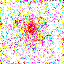

In [94]:
transforms.ToPILImage()(denormalize(denoised[1]))

In [95]:
with torch.no_grad():
    # model prediction (eps)
    noise_pred = unet(
        x_759,
        timesteps[1],
        c1,
        c2,
        timestep_cond=w_embedding,
    )
   
    # compute the previous noisy sample x_t -> x_t-1
    x_499, denoised = CM_scheduler.step(noise_pred, timesteps[1], x_759, return_dict=False)
    print(CM_scheduler.step_index)

2


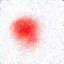

In [101]:
transforms.ToPILImage()(denormalize(denoised[2]))

In [102]:
with torch.no_grad():
    # model prediction (eps)
    noise_pred = unet(
        x_499,
        timesteps[2],
        c1,
        c2,
        timestep_cond=w_embedding,
    )
   
    # compute the previous noisy sample x_t -> x_t-1
    x_259, denoised = CM_scheduler.step(noise_pred, timesteps[2], x_499, return_dict=False)

In [103]:
print(CM_scheduler.step_index)

3


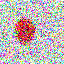

In [107]:
# transforms.ToPILImage()(denormalize(denoised[2]))
transforms.ToPILImage()(denormalize(x_259[2]))

In [108]:
with torch.no_grad():
    # model prediction (eps)
    noise_pred = unet(
        x_259,
        timesteps[3],
        c1,
        c2,
        timestep_cond=w_embedding,
    )
   
    # compute the previous noisy sample x_t -> x_t-1
    x_0, denoised = CM_scheduler.step(noise_pred, timesteps[3], x_259, return_dict=False)
    print(CM_scheduler.step_index)

4


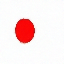

In [110]:
# transforms.ToPILImage()(denormalize(denoised[3]))
transforms.ToPILImage()(denormalize(x_0[2]))

In [128]:
with tqdm(reversed(range(num_inference_steps)), colour="#6565b5", total=num_inference_steps) as progress_bar:
    for i, t in enumerate(timesteps):
        x_i = x_i.to(dtype=torch.float32)
        # model prediction (eps)
        # no grad
        noise_pred = target_unet(
            x_i,
            t,
            c1,
            c2,
            timestep_cond=w_embedding,
        )

        # compute the previous noisy sample x_t -> x_t-1
        x_i, denoised = CM_scheduler.step(noise_pred, t, x_i, return_dict=False)

        if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % CM_scheduler.order == 0):
            progress_bar.update()

print(CM_scheduler.step_index)
# denormalize
image = denormalize(denoised)


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 12.78it/s]

4


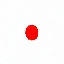

In [135]:
transforms.ToPILImage()(image[6])

In [8]:
from config import Zappo50K, toy_dataset, CelebA

# if args.dataset == "Zappo50K":
#     CFG = Zappo50K()
# elif args.dataset == "CelebA":
#     CFG = CelebA()
# else:
#    CFG = toy_dataset()
CFG = toy_dataset()

# missing = "Heel Slipper"
# targets = ["Flat Boot", "Flat Shoe", "Flat Slipper", "Flat Sandal", "Heel Boot", "Heel Shoe", "Heel Sandal"]
missing = "Gray_Hair Female"
targets = ["Brown_Hair Male", "Black_Hair Male", "Gray_Hair Male", "Blond_Hair Male", "Brown_Hair Female", "Black_Hair Female", "Blond_Hair Female"]

In [59]:
Sampler = DDIMSampler(
    model = teacher_unet,
    beta = (0.0001, 0.02),
    T = 1000,
    w = 1.8,
).to(accelerator.device)

In [62]:
x_i = torch.randn(1, 3, 64, 64).to(device)

In [107]:
CFG.ATR2IDX # 0,1,2,4

{'red': 0, 'green': 1, 'blue': 2, 'yellow': 3, 'black': 4, 'purple': 5}

In [153]:
CFG.OBJ2IDX #0,1,2

{'Circle': 0,
 'Rectangle': 1,
 'Triangle': 2,
 'Pentagon': 3,
 'Oval': 4,
 'Hexagon': 5}


100%|████████████████████████████████████| 50/50 [00:01<00:00, 47.83it/s, step=1, sample=1]


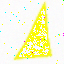

In [112]:
missing = "yellow Triangle"
atr, obj = CFG.ATR2IDX[missing.split(" ")[0]], CFG.OBJ2IDX[missing.split(" ")[-1]]
sample_batch = 1
x0 = torch.rand([3,64,64])
atr = torch.tensor(atr, dtype=torch.long, device=device).repeat(sample_batch)
obj = torch.tensor(obj, dtype=torch.long, device=device).repeat(sample_batch)

for j in range(1 // sample_batch):
    x_i = torch.randn(sample_batch, 3, 64, 64).to(device)
    x0 = Sampler(x_i, atr, obj, steps=50).squeeze(0)
    x0 = x0 * 0.5 + 0.5
    
to_pil_image(x0)

### Testing

In [32]:
# 2. Sample a random timestep for each image t_n from the ODE solver timesteps without bias.

start_ts, ts = get_ddim_timesteps(noise_scheduler, solver, args.train_batch_size, args.num_ddim_timesteps, device=device)

In [25]:
# 3. Get boundary scalings for start_timesteps and (end) timesteps.

c_skip_start, c_out_start = scalings_for_boundary_conditions(
    start_ts, timestep_scaling=args.timestep_scaling_factor)

c_skip, c_out = scalings_for_boundary_conditions(
    ts, timestep_scaling=args.timestep_scaling_factor)

c_skip_start, c_out_start = [append_dims(x, images.ndim) for x in [c_skip_start, c_out_start]]
#c_skip_start, c_out_start = [append_dims(x, 4) for x in [c_skip_start, c_out_start]]

c_skip, c_out = [append_dims(x, images.ndim) for x in [c_skip, c_out]]
#c_skip, c_out = [append_dims(x, 4) for x in [c_skip, c_out]]

NameError: name 'start_ts' is not defined

In [26]:
# 4. Sample noise from the prior and add it to the latents according to the noise magnitude at each
# timestep (this is the forward diffusion process) [z_{t_{n + k}} in Algorithm 1]
noisy_model_input = noise_scheduler.add_noise(image, start_ts)

NameError: name 'image' is not defined

In [33]:
# 5. Sample a random guidance scale w from U[w_min, w_max] and embed it
w = (args.w_max - args.w_min) * torch.rand((bsz,)) + args.w_min
w_embedding = guidance_scale_embedding(w, embedding_dim=args.time_cond_proj_dim)
w = w.reshape(bsz, 1, 1, 1)
# Move to U-Net device and dtype
w = w.to(device=img.device, dtype=img.dtype)
w_embedding = w_embedding.to(device=img.device, dtype=img.dtype)
# 6. Prepare prompt embeds and unet_added_conditions

In [517]:
image.device

device(type='cuda', index=0)

In [13]:
CFG = CelebA()
img = Image.open("./data/BrownHairM_01.jpg")
cond = "Brown_Hair Male"
bsz = 1
atr, obj = CFG.ATR2IDX[cond.split(" ")[0]], CFG.OBJ2IDX[cond.split(" ")[-1]]
atr = torch.tensor(atr, dtype=torch.long, device=device).repeat(1)
obj = torch.tensor(obj, dtype=torch.long, device=device).repeat(1)
transform = transforms.Compose([
    transforms.CenterCrop((178, 178)), # Crop the center to size (64, 64)
    transforms.Resize((64, 64)),
    transforms.ToTensor()            # Convert back to tensor
])

img = transform(img).to(device)
img = img.unsqueeze(0)
st = torch.tensor([199])
noisy_img = noise_scheduler.add_noise(img, timesteps=st)
noisy_model_input = noisy_img.repeat(bsz, 1, 1, 1).to(device)

NameError: name 'noise_scheduler' is not defined

In [331]:
solver.ddim_timesteps

tensor([ 19,  39,  59,  79,  99, 119, 139, 159, 179, 199, 219, 239, 259, 279,
        299, 319, 339, 359, 379, 399, 419, 439, 459, 479, 499, 519, 539, 559,
        579, 599, 619, 639, 659, 679, 699, 719, 739, 759, 779, 799, 819, 839,
        859, 879, 899, 919, 939, 959, 979, 999], device='cuda:0')

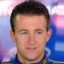

In [14]:
transforms.ToPILImage()(img.squeeze())

In [16]:
img.dim()

4

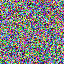

In [35]:
transforms.ToPILImage()(noisy_img.squeeze())

In [36]:
unet.to(device)

UNet(
  (time_embedding): TimeEmbedding(
    (cond_proj): Linear(in_features=128, out_features=128, bias=False)
    (emb_layer): Embedding(1000, 128)
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
    (act): Swish()
  )
  (atr_embedding): ConditionalEmbedding(
    (embedding_table): Embedding(5, 128)
    (emb): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Swish()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (obj_embedding): ConditionalEmbedding(
    (embedding_table): Embedding(3, 128)
    (emb): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): Swish()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepE

In [37]:
# 7. Get online LCM prediction on z_{t_{n + k}} (noisy_model_input), w, c, t_{n + k} (start_timesteps)
start_timesteps = st.repeat(bsz).to(device)
with torch.no_grad():
    noise_pred = unet(
        noisy_model_input,
        start_timesteps,
        atr,
        obj,
        timestep_cond=w_embedding.to(device),
    )

In [545]:
torch.cuda.empty_cache()

In [52]:
pred_x0 = get_predicted_original_sample(
    noise_pred,
    start_timesteps,
    noisy_model_input,
    noise_scheduler.config.prediction_type,
    noise_scheduler.alpha_schedule,
    noise_scheduler.sigma_schedule,
)
c_skip_start, c_out_start = scalings_for_boundary_conditions(
    start_timesteps, timestep_scaling=args.timestep_scaling_factor)

c_skip_start, c_out_start = [append_dims(x, noisy_model_input.ndim) for x in [c_skip_start, c_out_start]]
print(c_skip_start.shape)

model_pred = c_skip_start * noisy_model_input + c_out_start * pred_x0

torch.Size([1, 1, 1, 1])


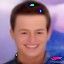

In [53]:
transforms.ToPILImage()(pred_x0[0])

In [54]:
start_timesteps

tensor([199], device='cuda:0')

In [55]:
# 8. Compute the conditional and unconditional teacher model predictions to get CFG estimates of the predicted noise eps_0 
# and predicted original sample x_0, then run the ODE solver using these estimates to predict the data point in the 
# augmented PF-ODE trajectory corresponding to the next ODE solver timestep.
weight_dtype = torch.float32
if args.mixed_precision:
    weight_dtype = torch.float16
# 1. Get teacher model prediction on noisy_model_input z_{t_{n + k}} and conditional embedding c
cond_teacher_output = teacher_unet(
    noisy_model_input.to(weight_dtype),
    start_timesteps,
    atr,
    obj
)

cond_pred_x0 = get_predicted_original_sample(
    cond_teacher_output,
    start_timesteps,
    noisy_model_input,
    noise_scheduler.config.prediction_type,
    noise_scheduler.alpha_schedule,
    noise_scheduler.sigma_schedule,
)
cond_pred_noise = get_predicted_noise(
    cond_teacher_output,
    start_timesteps,
    noisy_model_input,
    noise_scheduler.config.prediction_type,
    noise_scheduler.alpha_schedule,
    noise_scheduler.sigma_schedule,
)

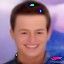

In [56]:
transforms.ToPILImage()(cond_pred_x0[0])

In [ ]:
pred_x0[0] - cond_pred_x0[0]

In [58]:
# 2. Get teacher model prediction on noisy_model_input z_{t_{n + k}} and unconditional embedding 0
uncond_teacher_output = teacher_unet(
    noisy_model_input.to(weight_dtype),
    start_timesteps,
    atr,
    obj,
    force_drop_ids=True
)
uncond_pred_x0 = get_predicted_original_sample(
    uncond_teacher_output,
    start_timesteps,
    noisy_model_input,
    noise_scheduler.config.prediction_type,
    noise_scheduler.alpha_schedule,
    noise_scheduler.sigma_schedule,
)
uncond_pred_noise = get_predicted_noise(
    uncond_teacher_output,
    start_timesteps,
    noisy_model_input,
    noise_scheduler.config.prediction_type,
    noise_scheduler.alpha_schedule,
    noise_scheduler.sigma_schedule,
)

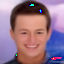

In [59]:
transforms.ToPILImage()(uncond_pred_x0[0])

In [60]:
w = w.to(noisy_model_input.device)

In [61]:
# 3. Calculate the CFG estimate of x_0 (pred_x0) and eps_0 (pred_noise)
# Note that this uses the LCM paper's CFG formulation rather than the Imagen CFG formulation
pred_x0 = cond_pred_x0 + w * (cond_pred_x0 - uncond_pred_x0)
pred_noise = cond_pred_noise + w * (cond_pred_noise - uncond_pred_noise)


In [84]:
# CFG test
pred_x0_test = cond_pred_x0[0] + torch.tensor([1.5]).to(w.device) * (cond_pred_x0[0] - uncond_pred_x0[0])

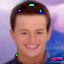

In [85]:
transforms.ToPILImage()(pred_x0_test)

In [350]:
index = torch.tensor([1]).repeat(32).long().to(w.device)
print(index.shape)

torch.Size([32])


In [268]:
solver.to(w.device)

In [126]:
# 4. Run one step of the ODE solver to estimate the next point x_prev on the
# augmented PF-ODE trajectory (solving backward in time)
# Note that the DDIM step depends on both the predicted x_0 and source noise eps_0.
index = torch.tensor([3]).repeat(32).long().to(w.device) # 399
x_prev = solver.ddim_step(pred_x0, pred_noise, index)

In [353]:
index

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

In [352]:
solver.ddim_alpha_cumprods[index]

tensor([0.9806, 0.9806, 0.9806, 0.9806, 0.9806, 0.9806, 0.9806, 0.9806, 0.9806,
        0.9806, 0.9806, 0.9806, 0.9806, 0.9806, 0.9806, 0.9806, 0.9806, 0.9806,
        0.9806, 0.9806, 0.9806, 0.9806, 0.9806, 0.9806, 0.9806, 0.9806, 0.9806,
        0.9806, 0.9806, 0.9806, 0.9806, 0.9806], device='cuda:0')

In [354]:
alpha_cumprod_prev = extract(solver.ddim_alpha_cumprods_prev, index, pred_x0_test.shape)
dir_xt = (1.0 - alpha_cumprod_prev[0]).sqrt() * pred_noise[0]
x_prev = alpha_cumprod_prev[0].sqrt() * pred_x0_test + dir_xt

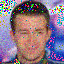

In [355]:
transforms.ToPILImage()(x_prev)

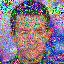

In [356]:
transforms.ToPILImage()(noisy_img.squeeze())

### Diffuser LCM test

In [14]:
dataset = SDText2ImageDataset(
    train_shards_path_or_url="pipe:curl -L -s https://huggingface.co/datasets/laion/conceptual-captions-12m-webdataset/resolve/main/data/{00000..01099}.tar?download=true",
    num_train_examples=40000,
    per_gpu_batch_size=1,
    #global_batch_size=12 * 2,
    global_batch_size=1,
    num_workers=8,
    resolution=512,
    interpolation_type="bilinear",
    shuffle_buffer_size=1000,
    pin_memory=True,
    persistent_workers=True,
)

train_dataloader = dataset.train_dataloader
train_iter = iter(train_dataloader)
    
compute_embeddings_fn = functools.partial(
    compute_embeddings,
    proportion_empty_prompts=0,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
)

In [16]:
train_batch = next(train_iter)

In [17]:
image, text = train_batch

In [12]:
device = torch.device('cuda')
weight_dtype = torch.float32

vae.to(device)
text_encoder.to(device)
diffuser_teacher.to(device)
diffuser_unet.to(device)
alpha_schedule = alpha_schedule.to(device)
sigma_schedule = sigma_schedule.to(device)

diffuser_solver = DDIMSolver(
    noise_scheduler_diffuser.alphas_cumprod.numpy(),
    timesteps=1000,
    ddim_timesteps=50)
diffuser_solver = diffuser_solver.to(device)

NameError: name 'vae' is not defined

In [25]:
uncond_input_ids = tokenizer([""] * image.shape[0], return_tensors="pt", padding="max_length", max_length=77).input_ids.to(device)
uncond_prompt_embeds = text_encoder(uncond_input_ids)[0]

image = image.to(device)
pixel_values = image.to(dtype=weight_dtype)
if vae.dtype != weight_dtype:
    vae.to(dtype=weight_dtype)

In [26]:
# encode pixel values with batch size of at most args.vae_encode_batch_size
vae_encode_batch_size = 1
latents = []
for i in range(0, pixel_values.shape[0], vae_encode_batch_size):
    latents.append(vae.encode(pixel_values[i : i + vae_encode_batch_size]).latent_dist.sample())
latents = torch.cat(latents, dim=0)

latents = latents * vae.config.scaling_factor
latents = latents.to(weight_dtype)
bsz = latents.shape[0]
noise = torch.randn_like(latents)


In [88]:
encoded_text = compute_embeddings_fn(text)
st = torch.tensor([39])
noisy_model_input = noise_scheduler_diffuser.add_noise(latents, noise, timesteps=st)
# noisy_model_input = noisy_img.repeat(bsz, 1, 1, 1).to(device)
start_timesteps = st.repeat(bsz).to(device)


In [84]:
print(noisy_model_input.shape)
print(start_timesteps.shape)
print(w_embedding.device)
print(prompt_embeds.shape)
print(encoded_text)


In [89]:
w = (args.w_max - args.w_min) * torch.rand((bsz,)) + args.w_min    
w_embedding = guidance_scale_embedding(w, embedding_dim=256)
w = w.reshape(bsz, 1, 1, 1)
# Move to U-Net device and dtype
w = w.to(device=image.device, dtype=image.dtype)
w_embedding = w_embedding.to(device=image.device, dtype=image.dtype)

In [85]:
#prompt_embeds = encoded_text.pop("prompt_embeds")
noise_pred = diffuser_unet(
    noisy_model_input,
    start_timesteps,
    timestep_cond=w_embedding,
    encoder_hidden_states=prompt_embeds.float(),
    added_cond_kwargs=encoded_text,
).sample

pred_x_0 = get_predicted_original_sample(
    noise_pred,
    start_timesteps,
    noisy_model_input,
    noise_scheduler_diffuser.config.prediction_type,
    alpha_schedule,
    sigma_schedule,
)

In [90]:
start_timesteps

tensor([39], device='cuda:0')

In [ ]:
transforms.ToPILImage()( * 0.5 + 0.5).squeeze()

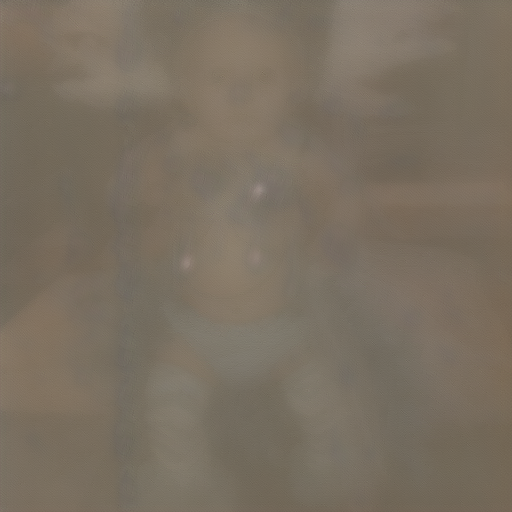

In [92]:
transforms.ToPILImage()((vae.decode(latents).sample * 0.5 + 0.5).squeeze())

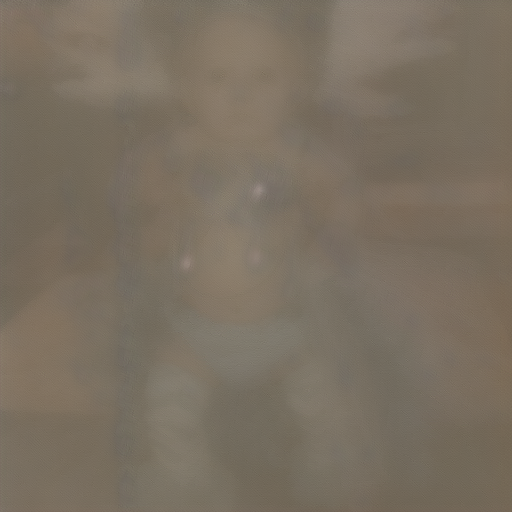

In [81]:
transforms.ToPILImage()((vae.decode(pred_x_0).sample * 0.5 + 0.5).squeeze())

In [52]:
cond_teacher_output = diffuser_teacher(
    noisy_model_input.to(weight_dtype),
    start_timesteps,
    encoder_hidden_states=prompt_embeds.to(weight_dtype),
).sample
cond_pred_x0 = get_predicted_original_sample(
    cond_teacher_output,
    start_timesteps,
    noisy_model_input,
    noise_scheduler_diffuser.config.prediction_type,
    alpha_schedule,
    sigma_schedule,
)
cond_pred_noise = get_predicted_noise(
    cond_teacher_output,
    start_timesteps,
    noisy_model_input,
    noise_scheduler_diffuser.config.prediction_type,
    alpha_schedule,
    sigma_schedule,
)

# 2. Get teacher model prediction on noisy_model_input z_{t_{n + k}} and unconditional embedding 0
uncond_teacher_output = diffuser_teacher(
    noisy_model_input.to(weight_dtype),
    start_timesteps,
    encoder_hidden_states=uncond_prompt_embeds.to(weight_dtype),
).sample
uncond_pred_x0 = get_predicted_original_sample(
    uncond_teacher_output,
    start_timesteps,
    noisy_model_input,
    noise_scheduler_diffuser.config.prediction_type,
    alpha_schedule,
    sigma_schedule,
)
uncond_pred_noise = get_predicted_noise(
    uncond_teacher_output,
    start_timesteps,
    noisy_model_input,
    noise_scheduler_diffuser.config.prediction_type,
    alpha_schedule,
    sigma_schedule,
)

In [58]:
# 3. Calculate the CFG estimate of x_0 (pred_x0) and eps_0 (pred_noise)
# Note that this uses the LCM paper's CFG formulation rather than the Imagen CFG formulation
pred_x0 = cond_pred_x0 + w * (cond_pred_x0 - uncond_pred_x0)
pred_noise = cond_pred_noise + w * (cond_pred_noise - uncond_pred_noise)
# 4. Run one step of the ODE solver to estimate the next point x_prev on the
# augmented PF-ODE trajectory (solving backward in time)
# Note that the DDIM step depends on both the predicted x_0 and source noise eps_0.
x_prev = diffuser_solver.ddim_step(pred_x0, pred_noise, torch.tensor([1]).to(device))

In [77]:
print(w.squeeze())

tensor(12.7816, device='cuda:0')


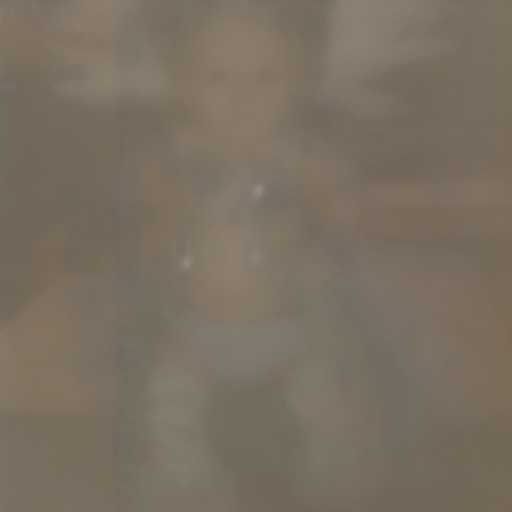

In [76]:
temp = cond_pred_x0 + torch.tensor([0.]).to(device) * (cond_pred_x0 - uncond_pred_x0)

transforms.ToPILImage()(
    (vae.decode(temp).sample * 0.5 + 0.5).squeeze()
)

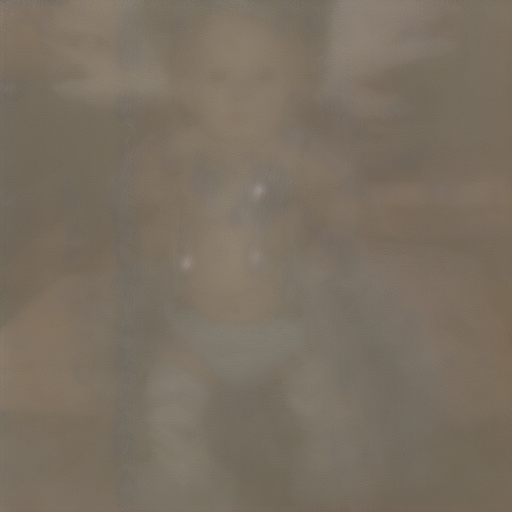

In [78]:
transforms.ToPILImage()(
    (vae.decode(x_prev).sample * 0.5 + 0.5).squeeze()
)

In [75]:
# 8. Compute the conditional and unconditional teacher model predictions to get CFG estimates of the
# predicted noise eps_0 and predicted original sample x_0, then run the ODE solver using these
# estimates to predict the data point in the augmented PF-ODE trajectory corresponding to the next ODE
# solver timestep.
with torch.no_grad():
    if torch.backends.mps.is_available():
        autocast_ctx = nullcontext()
    else:
        autocast_ctx = torch.autocast(accelerator.device.type)

    with autocast_ctx:
        # 1. Get teacher model prediction on noisy_model_input z_{t_{n + k}} and conditional embedding c
        cond_teacher_output = teacher_unet(
            noisy_model_input.to(weight_dtype),
            start_timesteps,
            encoder_hidden_states=prompt_embeds.to(weight_dtype),
        ).sample
        cond_pred_x0 = get_predicted_original_sample(
            cond_teacher_output,
            start_timesteps,
            noisy_model_input,
            noise_scheduler.config.prediction_type,
            alpha_schedule,
            sigma_schedule,
        )
        cond_pred_noise = get_predicted_noise(
            cond_teacher_output,
            start_timesteps,
            noisy_model_input,
            noise_scheduler.config.prediction_type,
            alpha_schedule,
            sigma_schedule,
        )

        # 2. Get teacher model prediction on noisy_model_input z_{t_{n + k}} and unconditional embedding 0
        uncond_teacher_output = teacher_unet(
            noisy_model_input.to(weight_dtype),
            start_timesteps,
            encoder_hidden_states=uncond_prompt_embeds.to(weight_dtype),
        ).sample
        uncond_pred_x0 = get_predicted_original_sample(
            uncond_teacher_output,
            start_timesteps,
            noisy_model_input,
            noise_scheduler.config.prediction_type,
            alpha_schedule,
            sigma_schedule,
        )
        uncond_pred_noise = get_predicted_noise(
            uncond_teacher_output,
            start_timesteps,
            noisy_model_input,
            noise_scheduler.config.prediction_type,
            alpha_schedule,
            sigma_schedule,
        )

        # 3. Calculate the CFG estimate of x_0 (pred_x0) and eps_0 (pred_noise)
        # Note that this uses the LCM paper's CFG formulation rather than the Imagen CFG formulation
        pred_x0 = cond_pred_x0 + w * (cond_pred_x0 - uncond_pred_x0)
        pred_noise = cond_pred_noise + w * (cond_pred_noise - uncond_pred_noise)
        # 4. Run one step of the ODE solver to estimate the next point x_prev on the
        # augmented PF-ODE trajectory (solving backward in time)
        # Note that the DDIM step depends on both the predicted x_0 and source noise eps_0.
        x_prev = solver.ddim_step(pred_x0, pred_noise, index)

NameError: name 'accelerator' is not defined

In [ ]:
from transformers import AutoTokenizer, CLIPTextModel, PretrainedConfig
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    LCMScheduler,
    StableDiffusionPipeline,
    UNet2DConditionModel,
)

In [117]:
# pretrained_teacher_model = "SimianLuo/LCM_Dreamshaper_v7"

# noise_scheduler_diffuser = DDPMScheduler.from_pretrained(
#      pretrained_teacher_model, subfolder="scheduler", revision=None)
# alpha_schedule = torch.sqrt(noise_scheduler_diffuser.alphas_cumprod)
# sigma_schedule = torch.sqrt(1 - noise_scheduler_diffuser.alphas_cumprod)

# diffuser_teacher = UNet2DConditionModel.from_pretrained(
#     pretrained_teacher_model, subfolder="unet", revision=None)

# tokenizer = AutoTokenizer.from_pretrained(
#     pretrained_teacher_model, subfolder="tokenizer", revision=None, use_fast=False)

# text_encoder = CLIPTextModel.from_pretrained(
#     pretrained_teacher_model, subfolder="text_encoder", revision=None) 

# vae = AutoencoderKL.from_pretrained(
#     pretrained_teacher_model,
#     subfolder="vae",
#     revision=None)

# vae.requires_grad_(False)
# text_encoder.requires_grad_(False)
# diffuser_teacher.requires_grad_(False)


In [ ]:
# diffuser_unet = UNet2DConditionModel.from_config(diffuser_teacher.config, time_cond_proj_dim=256)
# # load teacher_unet weights into unet
# diffuser_unet.load_state_dict(diffuser_teacher.state_dict(), strict=False)
# #diffuser_unet.train()
# diffuser_unet.requires_grad_(False)

In [ ]:
sum(p.numel() for p in diffuser_unet.parameters())
#diffuser_unet.down_blocks.

In [10]:
start_timesteps = solver.ddim_timesteps[0:20:2]

In [14]:
start_timesteps

tensor([ 19,  59,  99, 139, 179, 219, 259, 299, 339, 379])

In [15]:
timesteps = start_timesteps - 20
print(timesteps)

tensor([ -1,  39,  79, 119, 159, 199, 239, 279, 319, 359])


In [16]:
timesteps = torch.where(timesteps < 0, torch.zeros_like(timesteps), timesteps)
print(timesteps)

tensor([  0,  39,  79, 119, 159, 199, 239, 279, 319, 359])


In [13]:
img = Image.open("./data/BrownHairM_01.jpg")
transform = transforms.Compose([
    transforms.CenterCrop((178, 178)), # Crop the center to size (64, 64)
    transforms.Resize((64, 64)),
    transforms.ToTensor()            # Convert back to tensor
])

img = transform(img)
img = img.unsqueeze(0)

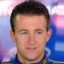

In [14]:
transforms.ToPILImage()(img.squeeze())

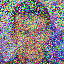

In [36]:
noisy_img , epsilon = noise_scheduler.add_noise(img, timesteps=torch.tensor([59]), return_epsilon=True)
transforms.ToPILImage()(noisy_img.squeeze())

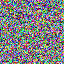

In [37]:
transforms.ToPILImage()(epsilon.squeeze())

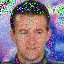

In [41]:
noisy_img_prev = noise_scheduler.add_noise(img, timesteps=torch.tensor([19]), epsilon=epsilon)
transforms.ToPILImage()(noisy_img_prev.squeeze())

In [48]:
current_epochs = np.arange(total_epochs)
k = 0.05  # Steepness of the curve
m = total_epochs // 1.6  # Midpoint of the transition
c_start = 1  # Initial value of c_ode
c_end = 0.1  # Final value of c_ode

# Sigmoid-based curve
curve = 1 / (1 + np.exp(-k * (current_epochs - m)))
c_ode = c_end + (c_start - c_end) * curve
c_t = 1 - c_ode


[1.0, 0.951229424500714, 0.9048374180359595, 0.8607079764250578, 0.8187307530779818, 0.7788007830714049, 0.7408182206817179, 0.7046880897187134, 0.6703200460356393, 0.6376281516217733, 0.6065306597126334, 0.5769498103804866, 0.5488116360940264, 0.522045776761016, 0.49658530379140947, 0.4723665527410147, 0.44932896411722156, 0.42741493194872665, 0.4065696597405991, 0.3867410234545012]
